## Make Diagnostic Plots of Data in DART-CAM6 Zarr Stores

In [1]:
import xarray as xr
import numpy as np
import intake

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from pathlib import Path
import os

import pprint
import json

## Create and Connect to a Dask Distributed Cluster

Run the cell below if the notebook is running on a NCAR supercomputer.
If the notebook is running on a different parallel computing environment, you will need 
to replace the usage of `NCARCluster` with a similar object from `dask_jobqueue` or `dask_gateway`.

In [2]:
import dask
from ncar_jobqueue import NCARCluster

num_jobs = 20
walltime = "2:00:00"
memory='20GB' 
cluster = NCARCluster(walltime=walltime, memory=memory)
cluster.scale(jobs=num_jobs)


from distributed import Client
client = Client(cluster)
cluster

/glade/work/bonnland/miniconda3/envs/lens-conversion/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40659 instead
  warnings.warn(


## Find and Obtain Data Using an Intake Catalog

#### Open catalog and produce a content summary

In [3]:
# Define the catalog description file location.   
catalog_url = "https://stratus.ucar.edu/ncar-dart-cam6/catalogs/aws-dart-cam6.json"

# Have the catalog interpret the "na-cordex-models" column as a list of values.
col = intake.open_esm_datastore(catalog_url)
col

,unique
variable,11
long_name,11
units,6
standard_name,10
vertical_levels,2
component,2
spatial_domain,1
start_time,2
end_time,2
frequency,2


In [4]:
# Produce a catalog content summary.
import pprint

uniques = col.unique(
    columns=["variable"]
)
pprint.pprint(uniques, compact=True, indent=4)

{   'variable': {   'count': 11,
                    'values': [   'CLDLIQ', 'Q', 'CLDICE', 'T', 'VS',
                                  'EFLX_LH_TOT', 'PS', 'HR', 'TSA', 'US',
                                  'ER']}}


#### Load data into xarray using the catalog

In [5]:
data_var = 'PS'

col_subset = col.search(variable=data_var)
col_subset

,unique
variable,1
long_name,1
units,1
standard_name,1
vertical_levels,1
component,1
spatial_domain,1
start_time,1
end_time,1
frequency,1


In [6]:
col_subset.df

,variable,long_name,units,standard_name,vertical_levels,component,spatial_domain,start_time,end_time,frequency,path
0,PS,Surface pressure,Pa,surface_air_pressure,1,atm,global,2011-01-03T00:00:00,2019-12-30T00:00:00,weekly,s3://ncar-dart-cam6/weekly/PS.zarr


In [7]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = col_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True, 'client_kwargs':{"endpoint_url":"https://stratus.ucar.edu/"}}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
store_name = dataset_key + ".zarr"

ds = dsets[dataset_key]
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'



Dataset dictionary keys:
 dict_keys(['PS.weekly.atm.1'])


,Array,Chunk
Bytes,15.52 GiB,50.00 MiB
Shape,"(80, 471, 192, 288)","(80, 80, 32, 32)"
Count,325 Tasks,324 Chunks
Type,float64,numpy.ndarray


## Define Plot Functions

#### Get consistently shaped data slices for both 2D and 3D variables.

In [9]:
def getSlice(ds, data_var):
    '''If the data has vertical levels, choose the level closest
       to the Earth's surface for 2-D diagnostic plots.
    '''
    data_slice = ds[data_var]

    if 'lev' in data_slice.dims:
        lastLevel = ds.lev.values[-1]
        data_slice = data_slice.sel(lev = lastLevel)
        data_slice = data_slice.squeeze()

    return data_slice

#### Get lat/lon dimension names 

In [8]:
def getSpatialDimensionNames(data_slice):
    '''Get the spatial dimension names for this data slice.
    '''
    # Determine lat/lon conventions for this slice.
    lat_dim = 'lat' if 'lat' in data_slice.dims else 'slat'
    lon_dim = 'lon' if 'lon' in data_slice.dims else 'slon'
    
    return [lat_dim, lon_dim]

### Create Time Series Spaghetti Plot of Ensemble Members

In [10]:
def plot_timeseries(ds, data_var, store_name):
    # Generate plot. 
    #
    figWidth = 25 
    figHeight = 20
    linewidth = 0.5

    numPlotsPerPage = 3
    numPlotCols = 1
    
    # Plot the aggregate statistics across time.
    fig, axs = plt.subplots(3, 1, figsize=(figWidth, figHeight))

    data_slice = getSlice(ds, data_var)
    spatial_dims = getSpatialDimensionNames(data_slice)

    unit_string = ds[data_var].attrs['units']

    # Try loading the slice so it's read from disk only once.
    #data_slice = data_slice.load()

    max_vals = data_slice.max(dim = spatial_dims).transpose()
    mean_vals = data_slice.mean(dim = spatial_dims).transpose()
    min_vals = data_slice.min(dim = spatial_dims).transpose()

    
    rangeMaxs = max_vals.max(dim = 'member_id')
    rangeMins = max_vals.min(dim = 'member_id')
    axs[0].set_facecolor('lightgrey')
    axs[0].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[0].plot(ds.time, max_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[0].set_title('Ensemble Member Maxima Over Time', fontsize=20)
    axs[0].set_ylabel(unit_string)

    rangeMaxs = mean_vals.max(dim = 'member_id')
    rangeMins = mean_vals.min(dim = 'member_id')
    axs[1].set_facecolor('lightgrey')
    axs[1].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[1].plot(ds.time, mean_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[1].set_title('Ensemble Member Means Over Time', fontsize=20)
    axs[1].set_ylabel(unit_string)

    rangeMaxs = min_vals.max(dim = 'member_id')
    rangeMins = min_vals.min(dim = 'member_id')
    axs[2].set_facecolor('lightgrey')
    axs[2].fill_between(ds.time, rangeMins, rangeMaxs, linewidth=linewidth, color='white')
    axs[2].plot(ds.time, min_vals, linewidth=linewidth, color='red', alpha=0.1)
    axs[2].set_title('Ensemble Member Minima Over Time', fontsize=20)
    axs[2].set_ylabel(unit_string)

    plt.suptitle(store_name, fontsize=25)
    
    return fig

### Make a Spaghetti Plot Showing All Ensemble Members

CPU times: user 24.7 s, sys: 1.37 s, total: 26.1 s
Wall time: 2min 32s


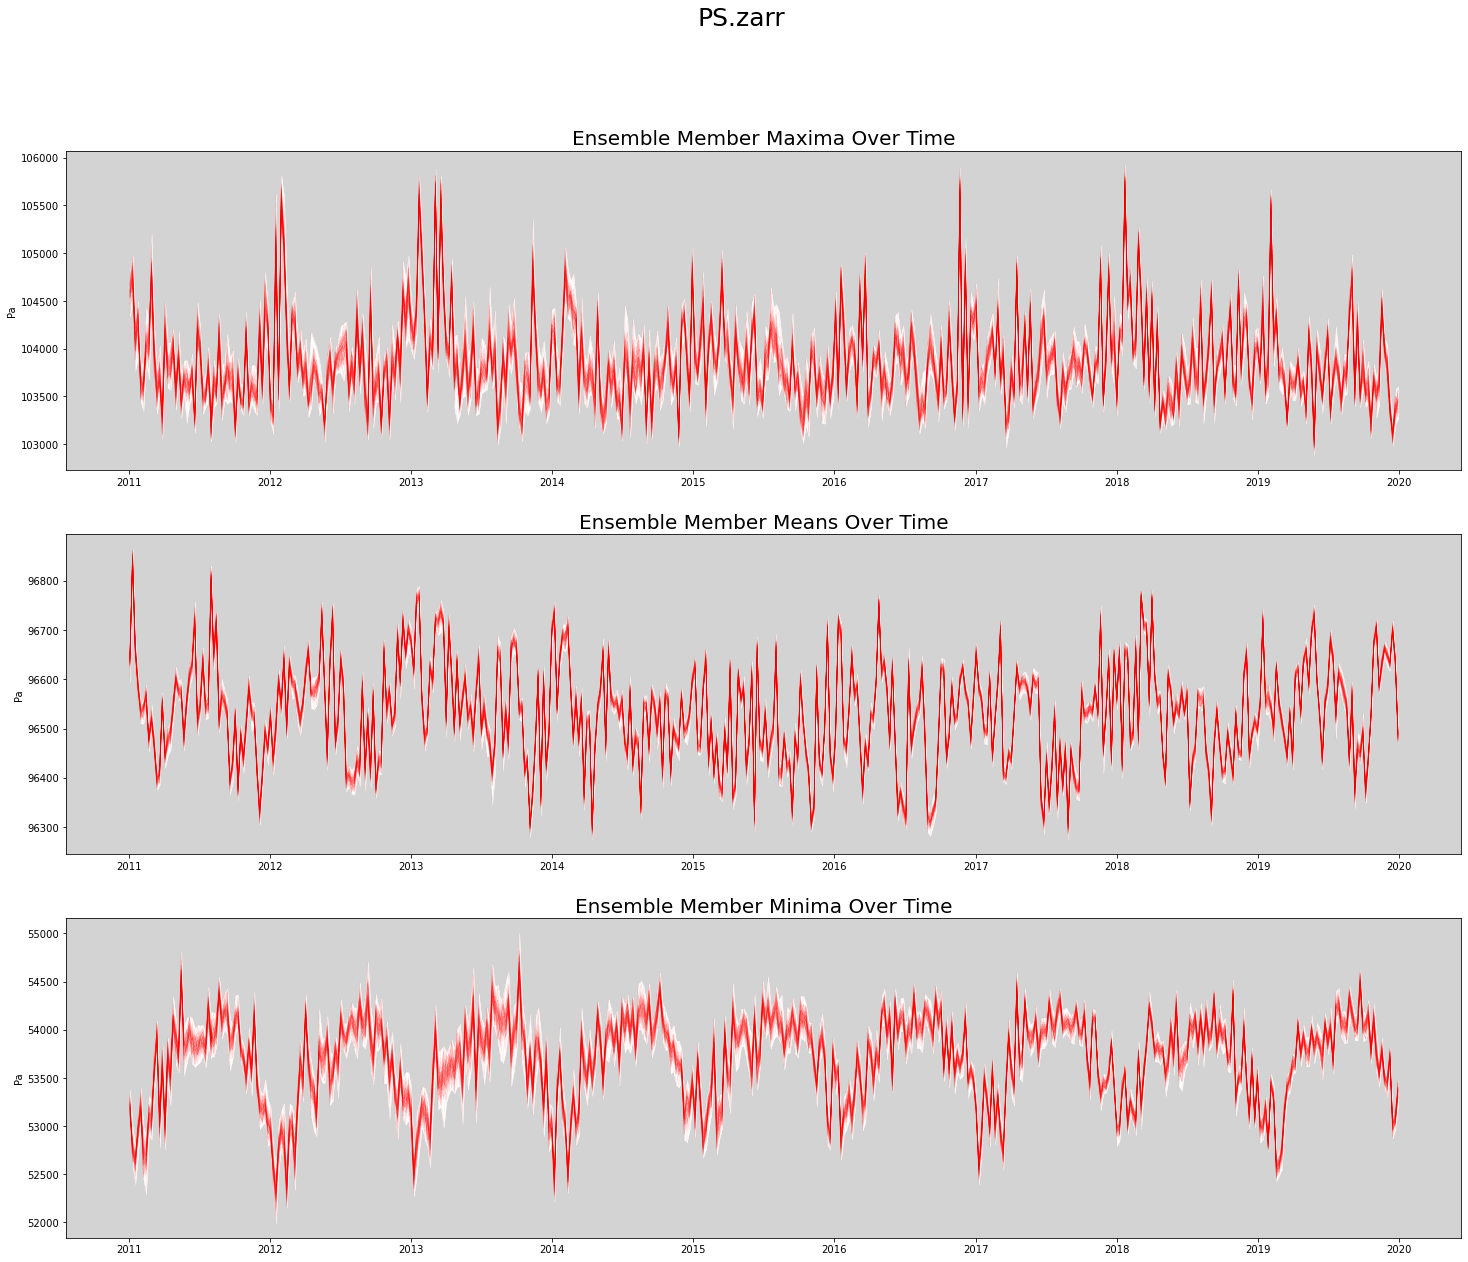

In [11]:
%%time

store_name = f'{data_var}.zarr'
fig = plot_timeseries(ds, data_var, store_name)

### Save/Download the figure

To download the figure plot file:
* Run the following command.
* Find the file using the Jupyter file browser in the left sidebar.
* Right-click the file name, and select "Download".

In [12]:
fig.savefig(f'{data_var}.zarr.pdf', facecolor='white', dpi=200)

### Release the Dask workers.

In [ ]:
cluster.close()

#### 